# Libraries

In cell below run <kbd>⇧ Shift</kbd>+<kbd>↵ Enter</kbd> in order to load libraries for this session

In [31]:
# The following loads in the major numerical and plotting libraries for python in a notebook
% pylab inline
# Load the probabilistic programming language pymc3
import pymc3 as pm

#import some special methods
from scipy.special import logit,expit

# set some plotting parameters to create ggplot-style plots
import seaborn as sns
import matplotlib as mpl
sns.set_context(context='talk',font_scale=1.5)
plt.style.use('ggplot')
mpl.rcParams['axes.labelsize'] = 24

Populating the interactive namespace from numpy and matplotlib


//anaconda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Background

The model makes use of a Bayesian analysis framework for a number of reasons

0. Bayesian analysis is __generative__. 

    This means that we're able to *re-create* our data multiple times through the Bayesian posterior. These multiple data-sets can then be used to build up an understanding of uncertainty.
    
0. It allows us to incorporate __prior knowledge__ of parameters.

    We can introduce literature-based estimates or expert opinion for things like overdose rate or prevalence of opioid use disorder. These priors can then be updated from data we present the model, however if the data is not informative of a given parameter, then at least we have the prior to fall back on. This is especially useful when dealing with possibly limited data.
    
0. We can incorporate __model structure__.
    
    Most Bayesian models can be written out like a recipe for how we believe our data is being generated. This allows us to incorporate not only processes driving what we're interested in (e.g. illicit opioid-use), but also processes that might bias the data (e.g. systematic under-reporting of overdoses).
    
0. We can incorporate multiple __data sources__.

    Similar to how we can factor in biases due to reporting of data, we can also incorporate how we believe the data should look. e.g. if there are a cluster of overdose cases that mean some months experience many more overdoses than in others then we could explcitly model the clustering effect of these cases (using a [negative-binomial](https://en.wikipedia.org/wiki/Negative_binomial_distribution) for example). In a standard logistic regression we may have to re-scale overdoses to deal with overly-dispersed data, but a Bayesian analysis allows us to be more explicit and transparent where the data came from and how it was generated.
    
Of course all analysis methods have their caveats and their limitations and Bayesian analysis is no exception. One tricky aspect can be in the actual fitting of data itself (drawing samples from the posterior in Bayesian nomenclature). Often its difficult to know if you have genuine independent samples from the posterior or not and many methods exist in order to test this. Approximate methods also exist for drawing from the posterior, but these methods may shrink the true uncertainty or provide a poor approximation when there is multi-modality in the posterior or exchangeability of parameters.

For more information see the book: [Gelman, Andrew, et al. Bayesian data analysis. 2013.](http://www.stat.columbia.edu/~gelman/book/)

## Simple example

Start with a simple data-generating process. Imagine there are $N$ individuals, and in a given month anyone of them has an equal probability of experiencing an overdose at prevalence $p$. 

Begin by fixing $N = 10000$, and $p = 0.01$ (i.e. ten-thousand people each have a 1% chance of experiencing an overdose). The number of overdoses in a month $x$, is drawn from a binomial distribution,

$$ x \sim \text{Bin}(N,p)$$

Code to generate 1000 samples of this process is given below,


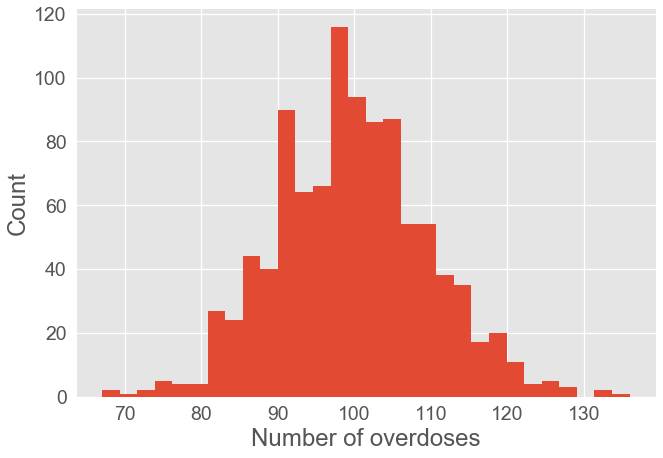

In [3]:
# define parameters
N,p = 10000,0.01

# perform draw
x = np.random.binomial(N,p,size=1000)

# plot histogram (add semi-colons to plt commands to suppress output)
plt.figure();
plt.hist(x,bins=30);
plt.xlabel('Number of overdoses');
plt.ylabel('Count');

### Hints

Use <kbd>↹ Tab</kbd> for auto-complete (helpful if can't remember exact commands). Use <kbd>⇧ Shift</kbd>+<kbd>↹ Tab</kbd> in order to view the doc-string for a particular method (helpful to see what method does and what input it takes).

### Adding in time

Instead of having a process that's being generated for just a given month, imagine instead we want to generate the process over a number of months. Draw samples of the number of overdoses for a year using the following,

In [6]:
# define parameters
N,p = 10000,0.01

# define number of months and number of samples
n_months = 12
n_samples = 1000

# generate data
x = np.random.binomial(N,p,size=(n_months,n_samples))

# check the shape of the data generated
print('Data generated is a {} by {} array'.format(*x.shape))

Data generated is a 12 by 1000 array


### Stylistic point

Define a method to create a plot of the time-series data. For the method we use the [numpy docstring](https://numpydoc.readthedocs.io/en/latest/format.html). This provides a consistent way of documenting methods and makes it easier to use automatic documentation such as [sphinx](http://www.sphinx-doc.org/en/master/).

In [13]:
def plot_data_timeseries(ys, xs=None,xlabel='Month',ylabel='Overdoses'):
    '''
    Plot 95 percentiles and interquartile range draws of time series data
    
    Parameters
    ----------
    
    ys : numpy array
        data to plot. In shape format (time,sample)
    x : numpy array
        1D array same size as ys 0 axis. Represents time-points
    xlabel : string
    ylabel : string
        
    Returns
    -------
    
    None
    
    '''
    color = '#E24A33'
    if xs is None:
        xs = np.arange(1,ys.shape[0]+1)
        
    plt.figure();
    lc,liqr,m,uiqr,uc = np.percentile(ys,[2.5,25.,50.,75.,97.5],axis=1);
    plt.fill_between(xs,lc,uc,alpha=0.25,color=color);
    plt.fill_between(xs,liqr,uiqr,alpha=0.25,color=color);
    plt.plot(xs,m,color=color);
    plt.xlabel(xlabel); plt.ylabel(ylabel);

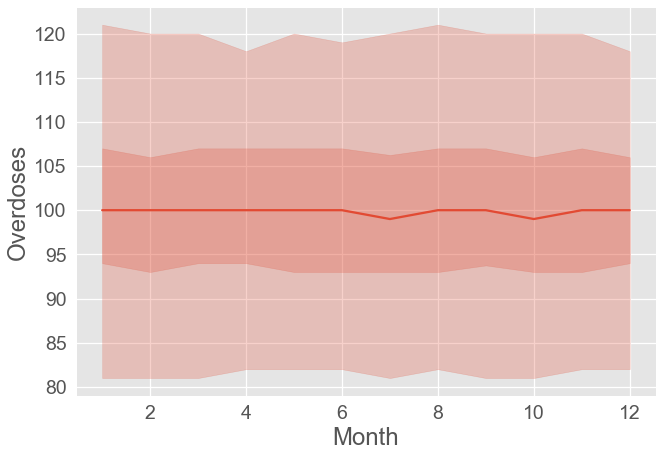

In [14]:
plot_data_timeseries(x)

## Adding in parameter uncertainty

It isn't just the number of overdoses that we may be uncertain about. We could also be uncertain about the underlying parameters as well. For our data-generating process we have point values for the size of the population $N$ and the prevalence of overdoses $p$. 

Let's assume our uncertainty in the size of the population is normally-distributed with mean 10000 and variance 1000 so,
$$N \sim N(10000,1000).$$

Prevalence of an overdose also has uncertainty associated with it. We can use the Beta distribution to characterise this. Imagine we had prior data for 100 individuals where 1 of them overdosed in a month. We can use an interpretation of the Beta distribution to characterise the uncertainty as,
$$p \sim B(\alpha,\beta).$$
where $\alpha = 1$ and is the number of overdoses (called successes in statistical literature), and $\beta = 99$, which is the number of non-overdoses (failures). We can create a method for our data generating process.

__Programming Notes:__ Here we use [broadcasting](https://docs.scipy.org/doc/numpy-1.15.0/user/basics.broadcasting.html) to replicate an array along a given axis. This allows us to not use a for loop and speeds up computation significantly. We also use a python [dictionary](https://docs.python.org/2/tutorial/datastructures.html#dictionaries) to return data, which helps to ensure we use the right variable in when analysing the data-generating process.


In [26]:
def overdose_generation():
    '''Create overdose samples for data-generating process.
    
    The population N has uncertainty and is drawn from a normal distribution. 
    The prevalence of overdoses in a given month is p and is drawn from a beta distribution.
    
    Parameters
    ----------
    None
    
    Returns
    -------
    dictionary
        Data generated for N,p, and x.
    '''
    
    # define number of months and number of samples
    n_months = 12
    n_samples = 1000
    
    #define prior for population size
    N_mean,N_var = 10000,1000
    # add singleton dimension to broadcast and convert into integer.
    N = np.random.normal(loc=N_mean,scale=np.sqrt(N_var),size=(1,n_samples)).astype(int) 
    
    #define prior for probability of an overdose
    p_alpha,p_beta = 1,99
    p = np.random.beta(p_alpha,p_beta,size=(1,n_samples))
    
    # generate data
    x = np.random.binomial(N,p,size=(n_months,n_samples))
    
    return {'N': N.flatten(), 'p': p.flatten(), 'x': x }

In [27]:
# create data
data = overdose_generation()

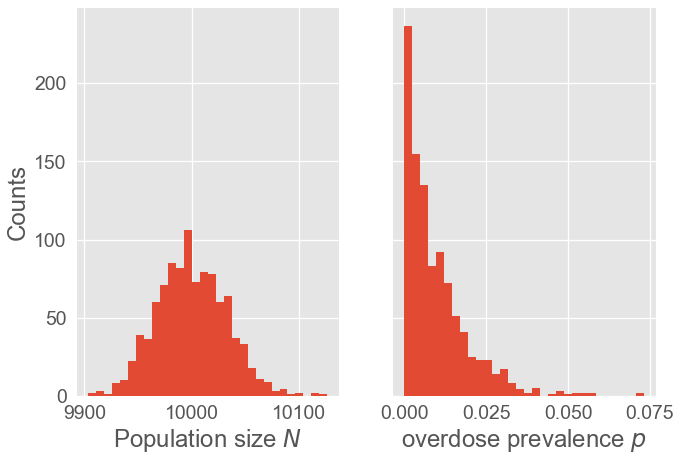

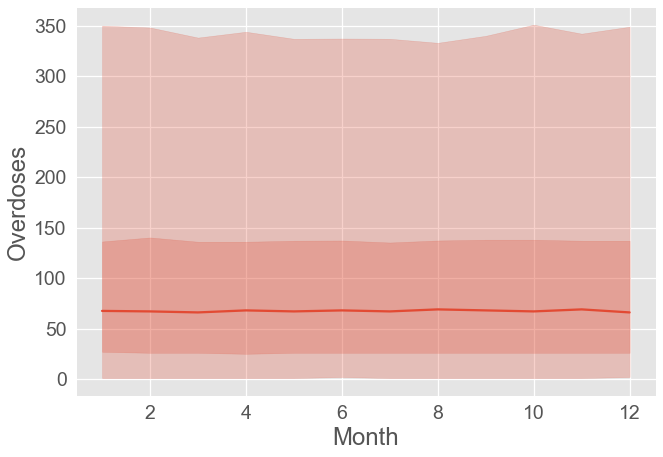

In [30]:
# plot data
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.hist(data['N'],bins=30);
ax1.set_ylabel('Counts');
ax1.set_xlabel('Population size $N$');

ax2.hist(data['p'],bins=30);
ax2.set_xlabel('overdose prevalence $p$');

plot_data_timeseries(data['x'])

### Incorporating uncertainty in time

As a final step let's imagine that the prevalence of overdoses can vary in time. We can assume that the prevalence of an overdose is only dependent on the overdoses in the previous month and there is a general increasing trend. The simplest way to incorporate this is to first define a random walk with drift, $w_t$. Each time-step can be normally distributed around the previous time-step with variance $\sigma_w^2$ and a drift $\mu_w$,

$$w_t \sim N(w_{t-1} + \mu_w,\sigma_w^2)$$

or alternatively,
$$w_t \sim w_{t-1} + N(\mu_w,\sigma_w^2)$$

Some examples are plotted below,

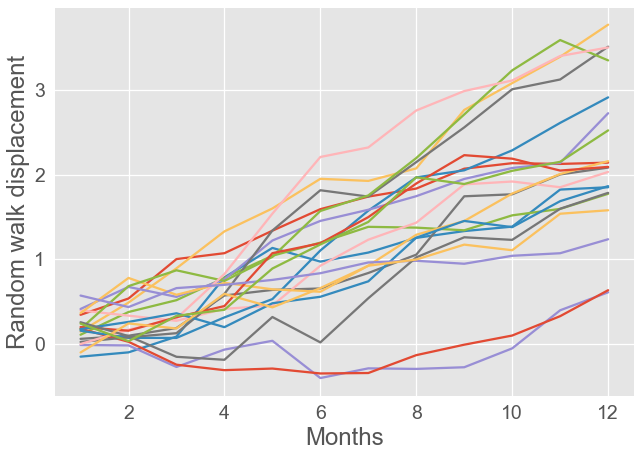

In [42]:
# time-points and samples
n_months,n_samples = 12,20

# define drift and variance
mu_w,sigma_w = 0.2,0.2

# sample errors
es = np.random.normal(loc=mu_w,scale=sigma_w,size=(n_months,n_samples))


ws = np.cumsum(es,axis=0)

plt.plot(np.arange(1,n_months+1),ws);
plt.xlabel('Months'); plt.ylabel('Random walk displacement');


In order to convert the random-walk $w_t$ into a probability $p_t$, we can transform it using the inverse-logit function,
$$p_t = \text{logit}^{-1}(w_t) = \frac{1}{1 + \exp(-w_t)}$$

Let's turn this into a method and plot some samples below,

In [74]:
def random_walk_prevalence(mu,sigma,initial_prevalence=0.01,shape=None):
    '''Create a random walk prevalence process with drift mu and variance sigma
    
    Parameters
    ----------
    mu : float
        drift of random walk in invlogit space
    sigma : float
        standard deviation of random walk in invlogit space
    shape : list
        shape of random walk in format (n_months,n_samples)
    
    Returns
    -------
    numpy array
        Samples of random walk process with shape (n_month,n_samples)
    
    '''
    
    # time-points and samples
    n_months,n_samples = shape


    # sample errors
    es = np.random.normal(loc=mu,scale=sigma,size=(n_months,n_samples))

    # create random walks with starting point equivalent to when prevalence is 0.01
    ws = logit(initial_prevalence) + np.cumsum(es,axis=0)

    # convert random walk into probability
    ps = expit(ws)
    
    return ps



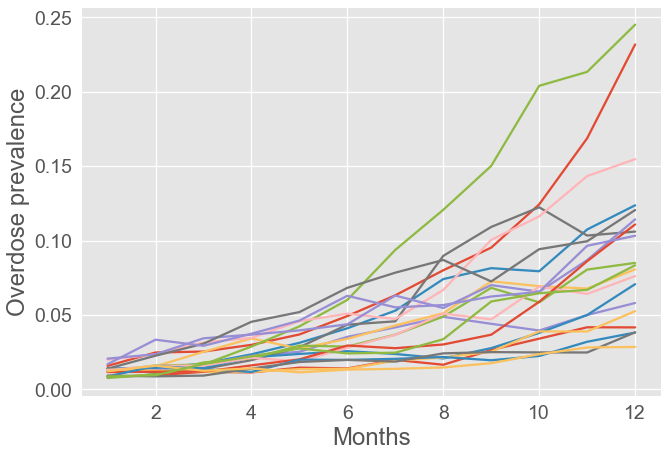

In [66]:
#define time-points and sample size
n_months,n_samples = 12,20

#generate samples
ps = random_walk_prevalence(0.2,0.2,shape=(n_months,n_samples))

# plot samples
plt.plot(np.arange(1,n_months+1),ps);
plt.xlabel('Months'); plt.ylabel('Overdose prevalence');

We can now adapt the `overdose_generation` method above to include a random-walk overdose prevalence as opposed to a fixed prevalence

In [69]:
def randomwalk_overdose_generation():
    '''Create overdose samples for data-generating process, where overdoses are a random walk in inverse logit space.
    
    The population N has uncertainty and is drawn from a normal distribution. 
    The prevalence of overdoses in a given month is p and is drawn from a beta distribution.
    
    Parameters
    ----------
    None
    
    Returns
    -------
    dictionary
        Data generated for N,p, and x.
    '''
    
    # define number of months and number of samples
    n_months = 12
    n_samples = 1000
    
    #define prior for population size
    N_mean,N_var = 10000,1000
    # add singleton dimension to broadcast and convert into integer.
    N = np.random.normal(loc=N_mean,scale=np.sqrt(N_var),size=(1,n_samples)).astype(int) 
    
    # define prior for probability of an overdose
    ## define drift and variance
    mu_w,sigma_w = 0.2,0.2
    p = random_walk_prevalence(mu_w,sigma_w,shape=(n_months,n_samples))
    
    # generate data
    x = np.random.binomial(N,p,size=(n_months,n_samples))
    
    return {'N': N.flatten(), 'p': p, 'x': x }

In [71]:
# create data
data = randomwalk_overdose_generation()

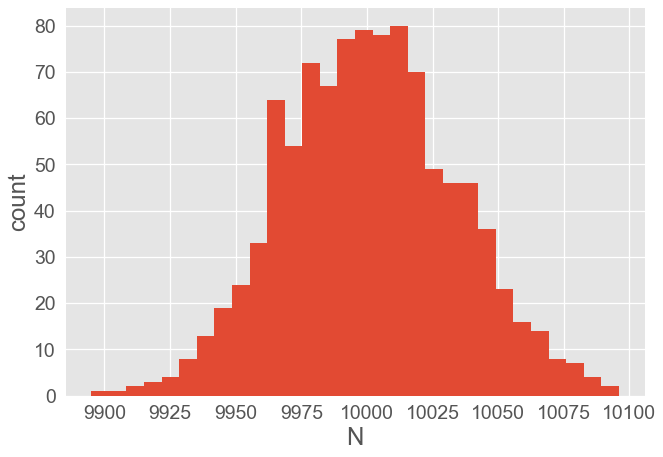

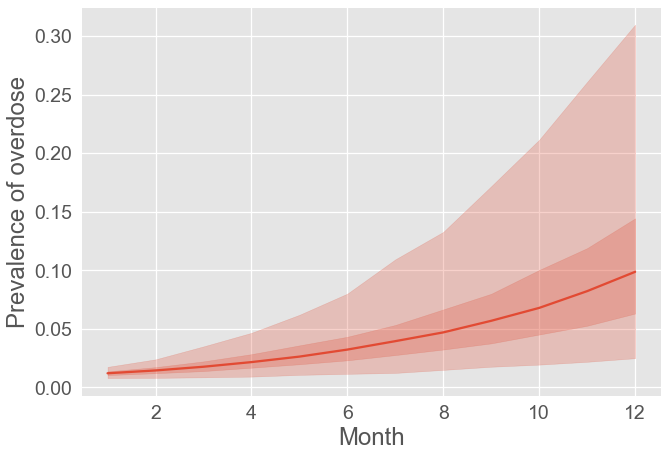

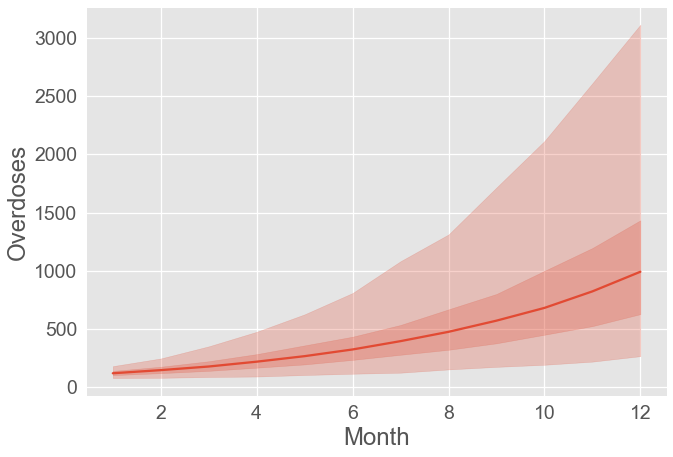

In [73]:
# plot data
plt.figure();
plt.hist(data['N'],bins=30);
plt.xlabel('N'); plt.ylabel('count');

plot_data_timeseries(data['p'],ylabel='Prevalence of overdose')

plot_data_timeseries(data['x'])

### Final steps

We've built up a data-generating model for a fixed population, with uncertainty experiencing overdoses that are binomially-distributed according to a time-varying process. This generation of data that is only  dependent on some hyper-parameters is known as the prior predictive check. It states what the model determines the process should look like before being exposed to data. To be fully Bayesian, we would have to estimate what each of these hyper-parameters should be, either through literature estimate or expert opinion. 

Re-define the method so that we can input the hyper-parameters and explore how this impacts the prior predictive check below.

In [78]:
def randomwalk_overdose_generation(N_mean = 10000, N_var = 1000, mu_w = 0.2,
                                   sigma_w = 0.2, n_months=12,n_samples=1000):
    '''Create overdose samples for data-generating process, where overdoses are a random walk in inverse logit space.
    
    The population N has uncertainty and is drawn from a normal distribution. 
    The prevalence of overdoses in a given month is p and is drawn from a beta distribution.
    
    Parameters
    ----------
    N_mean : float
        mean of population size
    N_var : float
        variance of population size
    mu_w : float
        drift of random walk in logit space
    sigma_w : float
        variance of random walk in logit space
    n_months : int
        number of months to simulate across
    n_samples : int
        number of samples to generate
    
    Returns
    -------
    dictionary
        Data generated for N,p, and x
    '''
    
    #define prior for population size
    N = np.random.normal(loc=N_mean,scale=np.sqrt(N_var),size=(1,n_samples)).astype(int) 
    
    # define prior for probability of an overdose
    p = random_walk_prevalence(mu_w,sigma_w,shape=(n_months,n_samples))
    
    # generate data
    x = np.random.binomial(N,p,size=(n_months,n_samples))
    
    return {'N': N.flatten(), 'p': p, 'x': x }

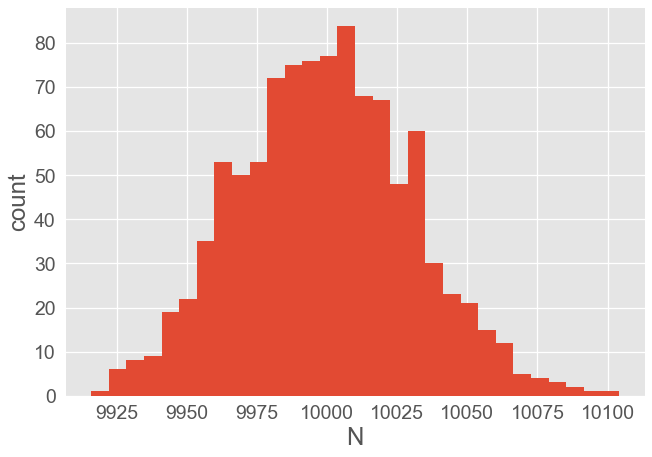

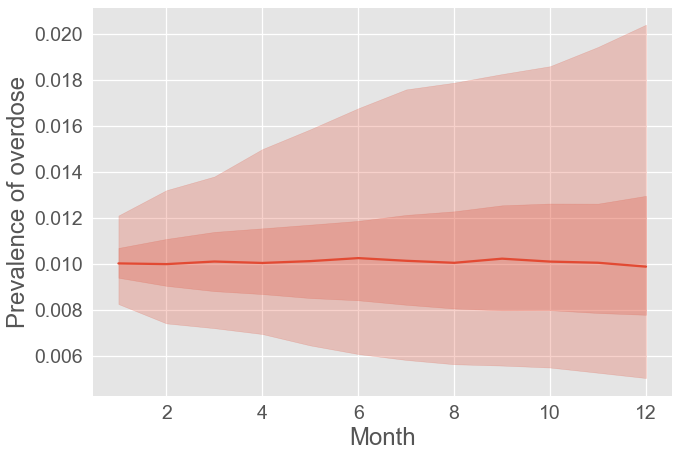

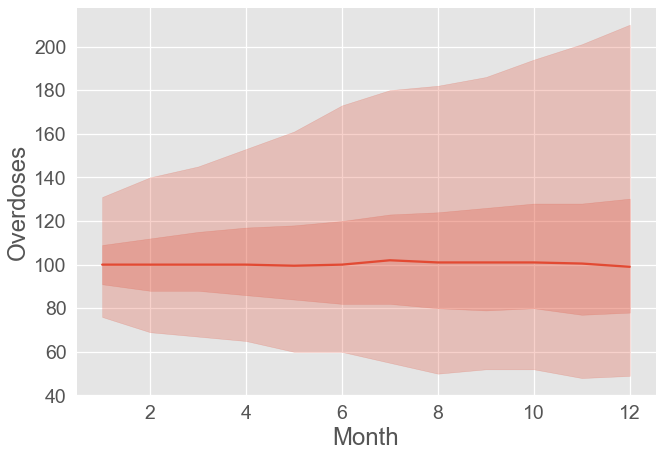

In [84]:
# create data
data = randomwalk_overdose_generation(N_mean = 10000, N_var = 1000, mu_w = 0.0,sigma_w = 0.1)

# plot data
plt.figure();
plt.hist(data['N'],bins=30);
plt.xlabel('N'); plt.ylabel('count');

plot_data_timeseries(data['p'],ylabel='Prevalence of overdose')

plot_data_timeseries(data['x'])

# Sensitivty Analyses

For more information on Bayesian model checking and sensitivity see Chapter 6 of Gelman: [Gelman, Andrew, et al. Bayesian data analysis. 2013.](http://www.stat.columbia.edu/~gelman/bayescomputation/bdachapter6.pdf)

## Leave one out cross validation

Want to know how much each individual dataset influences the results and how predictive the model is of that data. We can use a leave-one-out cross-validation scheme in order to accomplish this. For background on technique see [Sweeting, M. J., et al. *Estimating hepatitis C prevalence in England and Wales by synthesizing evidence from multiple data sources. Assessing data conflict and model fit.* Biostatistics 9.4 (2008): 715-734.](https://doi.org/10.1093/biostatistics/kxn004)

## Subjunctive Bayes

What if we were wrong about one of our priors? We can take a prior (for example, population at risk) and then change either the mean, variance or shape of the prior and then re-run analysis and compare posterior (this is known as subjunctive Bayes)

## Model comparison

Alternative model structures could be likely (e.g. what if probability of death following an overdose is being driven by other external factors?). We can re-create the model using these alternative hypotheses and re-fit to produce a posterior estimate. 

We can then either check:
0. The main model outcome to see if it robust to these changes
0. Use a Bayesian information criterion such as the Deviance Information Criterion (DIC) or Widely-Applicable Information Criterion (WAIC) in order to perform model selection